# Filter Strategy Configuration

This notebook uses a **Strategy Pattern** for filtering, allowing easy experimentation with different filter types:

- **none**: No filtering (pass-through)
- **highpass**: Remove DC bias and low-frequency drift
- **lowpass**: Smoothing filter (remove high-frequency noise)
- **bandpass**: Combination of high-pass and low-pass
- **moving_average**: Simple averaging filter (FIR)

The same filter configuration is used in both training and inference for consistency.

In [366]:
# Import filter strategies
import sys
import os
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), '..'))
from training.filter_strategies import create_filter

# ============================================================================
# FILTER CONFIGURATION - CHANGE THIS TO EXPERIMENT WITH DIFFERENT FILTERS
# ============================================================================
# Options: 'none', 'highpass', 'lowpass', 'bandpass', 'moving_average'

FILTER_TYPE = 'none'  # ← Change this to experiment
FILTER_CONFIG = {'cutoff': 0.5, 'order': 4}  # ← Parameters for the chosen filter

# Examples of other configurations:
# 
# No filtering:
#   FILTER_TYPE = 'none'
#   FILTER_CONFIG = {}
#
# Low-pass (smoothing):
#   FILTER_TYPE = 'lowpass'
#   FILTER_CONFIG = {'cutoff': 2.0, 'order': 4}
#
# Band-pass (combination):
#   FILTER_TYPE = 'bandpass'
#   FILTER_CONFIG = {'low_cutoff': 0.5, 'high_cutoff': 2.0, 'order': 4}
#
# Moving average (simple smoothing):
#   FILTER_TYPE = 'moving_average'
#   FILTER_CONFIG = {'window_size': 5}

print("="*80)
print("FILTER CONFIGURATION")
print("="*80)
print(f"Filter type: {FILTER_TYPE}")
print(f"Filter config: {FILTER_CONFIG}")
print("="*80)

FILTER CONFIGURATION
Filter type: none
Filter config: {'cutoff': 0.5, 'order': 4}


In [367]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler


# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Setup device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("⚠ GPU not available, using CPU")

PyTorch version: 2.5.1+cu121
Device: cuda
GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU
GPU Memory: 6.00 GB


## Fetch and clean data

## 📊 Sampling Rate Analysis

**CRITICAL**: We need to measure the ACTUAL sampling rate of our training data to ensure consistency with real-time inference.

This analysis will:

1. Calculate time differences between consecutive samples
1. Identify the actual sampling frequency
1. Update all filtering and processing to match this rate

In [368]:
# STEP 1: Load data and analyze timestamps
import os
import glob
import pandas as pd
import numpy as np

# Define data directories
dirs = [
    "../../data/tobias/raw"
]

# Collect all CSV file paths
csv_files = []
for d in dirs:
    csv_files.extend(glob.glob(os.path.join(d, "integrated_data_*.csv")))

print(f"Found {len(csv_files)} CSV files:")
for f in csv_files:
    print(f" - {f}")

# Read and concatenate all files
df_list = [pd.read_csv(f) for f in csv_files]
df = pd.concat(df_list, ignore_index=True)

print("\n" + "="*80)
print("RAW DATA INFO (combined)")
print("="*80)
print(f"Total combined shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst 5 rows:\n{df.head()}")

# Define numeric columns
numeric_columns = [
    'iteration', 'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3',
    'thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky'
]

# Convert to numeric
for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop corrupted rows
df_clean = df.dropna(subset=numeric_columns)

print(f"\nRows removed (corrupted/missing data): {len(df) - len(df_clean)}")
print(f"Clean data shape: {df_clean.shape}")

Found 3 CSV files:
 - ../../data/tobias/raw\integrated_data_20251116_184419.csv
 - ../../data/tobias/raw\integrated_data_20251116_222753.csv
 - ../../data/tobias/raw\integrated_data_20251117_011137.csv

RAW DATA INFO (combined)
Total combined shape: (145659, 17)
Columns: ['timestamp', 'iteration', 'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3', 'thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky', 'hand_label']

First 5 rows:
                    timestamp  iteration  env0  raw0  env1  raw1  env2  raw2  \
0  2025-11-16T18:46:41.768160          0   222   491   227   495    59   495   
1  2025-11-16T18:46:41.798506          1   222   491   227   495    59   495   
2  2025-11-16T18:46:41.845710          2   268   494   197   498    62   494   
3  2025-11-16T18:46:41.923268          3   224   496   261   498    59   495   
4  2025-11-16T18:46:41.984032          4   249   493   200   498    55   494   

   env3  raw3  thumb_tip  thumb_base   index  middle    ring   p


⚠️  CRITICAL: ACTUAL SAMPLING RATE ANALYSIS

📊 Temporal Statistics:
  Mean sample interval:   0.1798 seconds
  Median sample interval: 0.0627 seconds
  Std deviation:          32.8619 seconds
  Min interval:           0.0125 seconds
  Max interval:           10599.1670 seconds

🎯 IMPLIED SAMPLE RATE:    5.56 Hz

⚠️  HARDCODED ASSUMPTION:   29.02 Hz (fs = 1/0.03446)

❌ MISMATCH:               23.46 Hz difference!


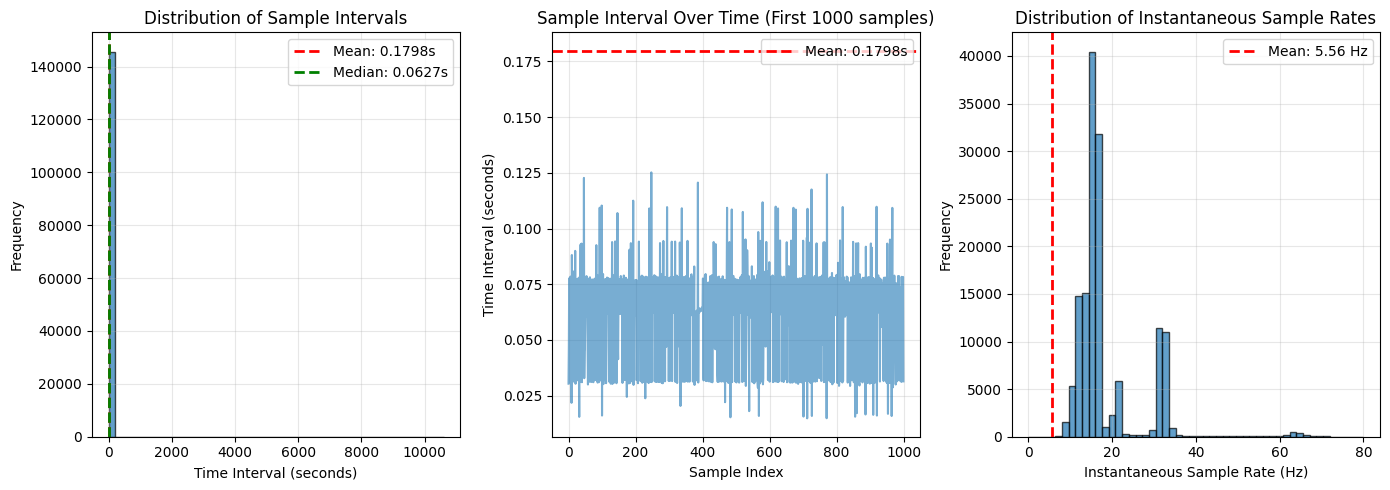


✅ Using MEASURED_SAMPLE_RATE = 5.5615 Hz for all subsequent processing


In [369]:
# STEP 2: ANALYZE ACTUAL SAMPLING RATE FROM TIMESTAMPS
print("\n" + "="*80)
print("⚠️  CRITICAL: ACTUAL SAMPLING RATE ANALYSIS")
print("="*80)

# Convert timestamp to datetime
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])
df_clean = df_clean.sort_values('timestamp').reset_index(drop=True)

# Calculate time differences between consecutive samples
time_diffs = df_clean['timestamp'].diff().dt.total_seconds()

# Remove NaN from first row
time_diffs_valid = time_diffs.dropna()

# Calculate statistics
mean_interval = time_diffs_valid.mean()
median_interval = time_diffs_valid.median()
std_interval = time_diffs_valid.std()
min_interval = time_diffs_valid.min()
max_interval = time_diffs_valid.max()

# Calculate actual sampling rate
actual_sample_rate = 1.0 / mean_interval

print(f"\n📊 Temporal Statistics:")
print(f"  Mean sample interval:   {mean_interval:.4f} seconds")
print(f"  Median sample interval: {median_interval:.4f} seconds")
print(f"  Std deviation:          {std_interval:.4f} seconds")
print(f"  Min interval:           {min_interval:.4f} seconds")
print(f"  Max interval:           {max_interval:.4f} seconds")
print(f"\n🎯 IMPLIED SAMPLE RATE:    {actual_sample_rate:.2f} Hz")
print(f"\n⚠️  HARDCODED ASSUMPTION:   {1.0/0.03446:.2f} Hz (fs = 1/0.03446)")
print(f"\n❌ MISMATCH:               {abs(actual_sample_rate - 1.0/0.03446):.2f} Hz difference!")

# Visualize distribution of time intervals
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.hist(time_diffs_valid, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(mean_interval, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_interval:.4f}s')
plt.axvline(median_interval, color='green', linestyle='--', linewidth=2, label=f'Median: {median_interval:.4f}s')
plt.xlabel('Time Interval (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Sample Intervals')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(time_diffs_valid.values[:1000], alpha=0.6)
plt.axhline(mean_interval, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_interval:.4f}s')
plt.xlabel('Sample Index')
plt.ylabel('Time Interval (seconds)')
plt.title('Sample Interval Over Time (First 1000 samples)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
sample_rates = 1.0 / time_diffs_valid
plt.hist(sample_rates, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(actual_sample_rate, color='red', linestyle='--', linewidth=2, label=f'Mean: {actual_sample_rate:.2f} Hz')
plt.xlabel('Instantaneous Sample Rate (Hz)')
plt.ylabel('Frequency')
plt.title('Distribution of Instantaneous Sample Rates')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Store the actual measured sample rate for later use
MEASURED_SAMPLE_RATE = actual_sample_rate
print(f"\n✅ Using MEASURED_SAMPLE_RATE = {MEASURED_SAMPLE_RATE:.4f} Hz for all subsequent processing")
print("="*80)

In [370]:
sensor_columns = ['env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3']
finger_columns = ['thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky']

sensor_indices = [numeric_columns.index(col) for col in sensor_columns]
finger_indices = [numeric_columns.index(col) for col in finger_columns]

print("="*60)
print("DATA CONFIGURATION")
print("="*60)
print(f"Sensor columns (inputs): {sensor_columns}")
print(f"Sensor indices: {sensor_indices}")
print(f"Number of input features: {len(sensor_indices)}")
print(f"\nFinger columns (outputs): {finger_columns}")
print(f"Finger indices: {finger_indices}")
print(f"Number of output features: {len(finger_indices)}")

DATA CONFIGURATION
Sensor columns (inputs): ['env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3']
Sensor indices: [1, 2, 3, 4, 5, 6, 7, 8]
Number of input features: 8

Finger columns (outputs): ['thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky']
Finger indices: [9, 10, 11, 12, 13, 14]
Number of output features: 6


In [371]:
# USE THE MEASURED SAMPLE RATE (not hardcoded assumption!)
fs = MEASURED_SAMPLE_RATE

# Create filter using strategy pattern (configured at top of notebook)
filter_strategy = create_filter(FILTER_TYPE, fs, **FILTER_CONFIG)

print("="*80)
print("APPLYING FILTER TO ENV CHANNELS")
print("="*80)
print(f"✅ Using MEASURED sampling rate: {fs:.4f} Hz")
print(f"   {filter_strategy.get_description()}")
print("="*80)

# Apply filtering to env channels using the chosen strategy
for col in ['env0', 'env1', 'env2', 'env3']:
    df_clean[col] = filter_strategy.apply_batch(df_clean[col].values)

print("\n✅ Filtering complete - model will match streaming inference behavior!")
print(f"   Filter type: {FILTER_TYPE}")
print(f"   Filter config: {FILTER_CONFIG}")
print("="*80)

APPLYING FILTER TO ENV CHANNELS
✅ Using MEASURED sampling rate: 5.5615 Hz
   No Filter (pass-through)

✅ Filtering complete - model will match streaming inference behavior!
   Filter type: none
   Filter config: {'cutoff': 0.5, 'order': 4}


### 🔧 Filter Strategy Pattern

**Current Setup: Configurable filtering with Strategy Pattern**

The notebook now uses a **configurable filter strategy** set at the top:

- `FILTER_TYPE`: Choose from 'none', 'highpass', 'lowpass', 'bandpass', 'moving_average'
- `FILTER_CONFIG`: Parameters specific to the chosen filter

**Available Filters:**

- **none**: No filtering (pass-through) - use for already clean data
- **highpass**: Remove DC bias and slow drift - good for EMG baseline wander
- **lowpass**: Smoothing filter - reduces high-frequency noise
- **bandpass**: Combined high-pass and low-pass - removes both drift and noise
- **moving_average**: Simple FIR smoothing - no ringing artifacts

**Why CAUSAL filtering (`lfilter`):**

- ✅ Processes data sequentially (sample-by-sample)
- ✅ Only uses past and present data (no lookahead)
- ✅ **Matches streaming inference behavior exactly**
- ⚠️ May introduce phase shift (except for FIR filters like moving_average)

**Consistency is Critical:**

- Filter configuration is automatically saved with the model checkpoint
- Inference script loads the same filter configuration
- This ensures training and deployment see identical filtered patterns

**To experiment with different filters:**

1. Change `FILTER_TYPE` and `FILTER_CONFIG` at the top of the notebook
1. Re-run the filtering cell and all subsequent cells
1. Retrain the model
1. The new filter config will be saved automatically

In [372]:
X = df_clean[sensor_columns].values.astype(np.float32)
y = df_clean[finger_columns].values.astype(np.float32)

# Create scalers
scaler_X = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = y

print("="*60)
print("NORMALIZATION INFO")
print("="*60)
print("Input feature means (after scaling):", X_scaled.mean(axis=0))
print("Input feature stds (after scaling):", X_scaled.std(axis=0))

NORMALIZATION INFO
Input feature means (after scaling): [-3.3522216e-09  1.5923053e-08 -1.6761108e-09 -4.1902770e-10
  8.3805540e-09 -1.4246942e-08  1.1732776e-08 -7.8567694e-11]
Input feature stds (after scaling): [1.         1.         1.         1.         1.         0.99999994
 1.         1.        ]


In [373]:
# Save scaler for inference
import joblib

joblib.dump(scaler_X, "../../data/tobias/scaler_inputs_lstm.pkl")
print("Scaler saved to scaler_inputs_lstm.pkl")
print(f"Note: Data was filtered using {FILTER_TYPE} filter")
print(f"      Filter config: {FILTER_CONFIG}")

Scaler saved to scaler_inputs_lstm.pkl
Note: Data was filtered using none filter
      Filter config: {'cutoff': 0.5, 'order': 4}


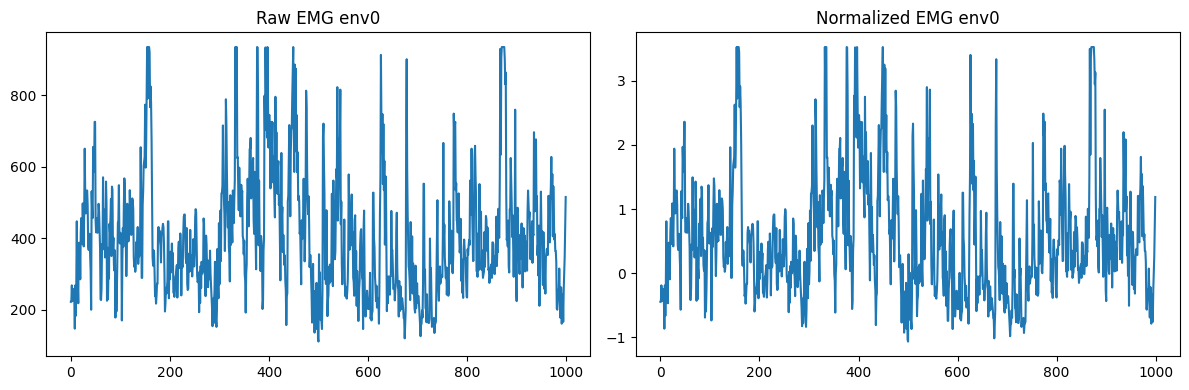

In [374]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Raw EMG env0")
plt.plot(X[:, 0][:1000])  # first 1000 samples
plt.subplot(1, 2, 2)
plt.title("Normalized EMG env0")
plt.plot(X_scaled[:, 0][:1000])
plt.tight_layout()
plt.show()

In [375]:
from sklearn.preprocessing import StandardScaler

# Define neighbor relationships (1-indexed for readability)
neighbors = {
    1: [2],          
    2: [1, 4],         
    3: [4],      
    4: [2, 3]          
}

# Compute raw and env neighbor differences
for base in range(1, 5):  
    raw_base = f'raw{base-1}'
    env_base = f'env{base-1}'
    
    if not neighbors[base]:
        df_clean[f'raw_diff{base}'] = 0.0
        df_clean[f'env_diff{base}'] = 0.0
    else:
        raw_diffs = [df_clean[raw_base] - df_clean[f'raw{n-1}'] for n in neighbors[base]]
        env_diffs = [df_clean[env_base] - df_clean[f'env{n-1}'] for n in neighbors[base]]
        # Average if multiple neighbors
        df_clean[f'raw_diff{base}'] = sum(raw_diffs) / len(raw_diffs)
        df_clean[f'env_diff{base}'] = sum(env_diffs) / len(env_diffs)

additional_features = [f'raw_diff{i}' for i in range(1, 5)] + [f'env_diff{i}' for i in range(1, 5)]

print("\nAdded engineered features:")
print(additional_features)

sensor_columns = [
    'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3',
    *additional_features
]

X = df_clean[sensor_columns].values.astype(np.float32)

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Add normalized columns back to DataFrame
for i, col in enumerate(sensor_columns):
    df_clean[col + '_norm'] = X_scaled[:, i]

print(f"\nFinal numeric data shape: {df_clean.shape}")
print(f"Columns after feature engineering: {list(df_clean.columns)}")


Added engineered features:
['raw_diff1', 'raw_diff2', 'raw_diff3', 'raw_diff4', 'env_diff1', 'env_diff2', 'env_diff3', 'env_diff4']

Final numeric data shape: (145659, 41)
Columns after feature engineering: ['timestamp', 'iteration', 'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3', 'thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky', 'hand_label', 'raw_diff1', 'env_diff1', 'raw_diff2', 'env_diff2', 'raw_diff3', 'env_diff3', 'raw_diff4', 'env_diff4', 'env0_norm', 'raw0_norm', 'env1_norm', 'raw1_norm', 'env2_norm', 'raw2_norm', 'env3_norm', 'raw3_norm', 'raw_diff1_norm', 'raw_diff2_norm', 'raw_diff3_norm', 'raw_diff4_norm', 'env_diff1_norm', 'env_diff2_norm', 'env_diff3_norm', 'env_diff4_norm']

Final numeric data shape: (145659, 41)
Columns after feature engineering: ['timestamp', 'iteration', 'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3', 'thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky', 'hand_label', 'raw_diff1', 'env_diff1', 'ra

In [376]:
# Save scaler for inference
import joblib
joblib.dump(scaler_X, "../../data/tobias/scaler_inputs_lstm.pkl")
print(f"Scaler saved with {scaler_X.n_features_in_} features")

Scaler saved with 16 features


In [377]:
# Hyperparameters
batch_size = 50
learning_rate = 1e-3
warmup_epochs = 5
max_epochs = 200
eta_min = 1e-6
window_size = 50
stride = 5
hidden_size = 128
num_layers = 3
dropout = 0.4

## Windows

In [378]:
import numpy as np

def create_windows(X, y, window_size=30, stride=5, pred_delay=0):
    """
    Convert continuous time-series into overlapping windows for sequence modeling.

    Args:
        X (ndarray): shape (n_samples, n_features)
        y (ndarray): shape (n_samples, n_targets)
        window_size (int): number of samples per window
        stride (int): hop size between windows
        pred_delay (int): how far ahead the label is predicted

    Returns:
        X_win: (n_windows, window_size, n_features)
        y_win: (n_windows, n_targets)
    """
    Xs, ys = [], []
    for i in range(0, len(X) - window_size - pred_delay, stride):
        Xs.append(X[i : i + window_size])
        ys.append(y[i + window_size + pred_delay - 1])
    return np.stack(Xs), np.stack(ys)


X_win, y_win = create_windows(X_scaled, y_scaled, window_size=window_size, stride=stride)
print(f"Windows: {X_win.shape}, Targets: {y_win.shape}")

Windows: (29122, 50, 16), Targets: (29122, 6)


In [379]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_tensor = torch.tensor(X_win, dtype=torch.float32)
y_tensor = torch.tensor(y_win, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

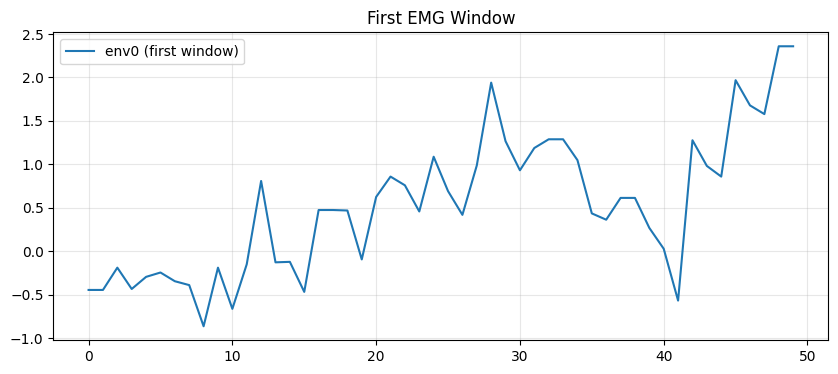

In [380]:
plt.figure(figsize=(10, 4))
plt.plot(X_win[0, :, 0], label="env0 (first window)")
plt.title("First EMG Window")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Training

In [381]:
class LSTMModel(nn.Module):
    def __init__(self, n_inputs, n_outputs, hidden_size=128, num_layers=2, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Create individual LSTM layers for skip connections
        self.lstm_layers = nn.ModuleList()
        for i in range(num_layers):
            input_size = n_inputs if i == 0 else hidden_size
            self.lstm_layers.append(
                nn.LSTM(
                    input_size=input_size,
                    hidden_size=hidden_size,
                    num_layers=1,
                    batch_first=True
                )
            )
        
        # Dropout layers between LSTM layers
        if num_layers > 1:
            self.dropout = nn.Dropout(dropout)
        
        # Projection layer to match dimensions for skip connections
        self.input_projection = nn.Linear(n_inputs, hidden_size) if n_inputs != hidden_size else None
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, n_outputs)
        
    def forward(self, x):
        # x shape: (batch, seq_len, features)
        
        # Store skip connections
        skip_connections = []
        
        # First LSTM layer
        out, _ = self.lstm_layers[0](x)
        
        # Project input to match hidden_size for skip connection
        if self.input_projection is not None:
            x_projected = self.input_projection(x)
        else:
            x_projected = x
        
        skip_connections.append(x_projected)
        
        # Remaining LSTM layers with skip connections
        for i in range(1, self.num_layers):
            if self.num_layers > 1:
                out = self.dropout(out)
            
            # Add skip connection from previous layer
            out = out + skip_connections[-1]
            
            # Pass through LSTM layer
            out, _ = self.lstm_layers[i](out)
            
            # Store current output for next skip connection
            skip_connections.append(out)
        
        # Take the last time step output
        last_output = out[:, -1, :]
        
        # Pass through fully connected layer
        output = self.fc(last_output)
        return output

In [382]:
X_tensor = torch.tensor(X_win, dtype=torch.float32)
y_tensor = torch.tensor(y_win, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)

# Split into train/test
n_train = int(len(dataset) * 0.8)
train_set, test_set = torch.utils.data.random_split(dataset, [n_train, len(dataset) - n_train])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

Train batches: 466, Test batches: 117



In [383]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class AdaptiveCosineAnnealingWarmupLR(_LRScheduler):
    def __init__(self, optimizer, warmup_epochs, max_epochs, eta_min=0, last_epoch=-1):
        """
        Args:
            optimizer (Optimizer): Wrapped optimizer.
            warmup_epochs (int): Number of warmup epochs.
            max_epochs (int): Total number of epochs.
            eta_min (float): Minimum learning rate. Default: 0.
            last_epoch (int): The index of the last epoch. Default: -1.
        """
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs
        self.eta_min = eta_min
        super(AdaptiveCosineAnnealingWarmupLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_epochs:
            # Warmup phase
            return [
                base_lr * (self.last_epoch + 1) / self.warmup_epochs
                for base_lr in self.base_lrs
            ]
        else:
            # Cosine annealing phase
            return [
                self.eta_min + (base_lr - self.eta_min) * 
                (1 + math.cos(math.pi * (self.last_epoch - self.warmup_epochs) / 
                              (self.max_epochs - self.warmup_epochs))) / 2
                for base_lr in self.base_lrs
            ]

In [384]:
from tqdm import trange, tqdm

n_inputs = X_tensor.shape[2]
n_outputs = y_tensor.shape[1]

model = LSTMModel(n_inputs, n_outputs, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = AdaptiveCosineAnnealingWarmupLR(optimizer, warmup_epochs=warmup_epochs, max_epochs=max_epochs, eta_min=eta_min)
criterion = nn.MSELoss()

train_losses, test_losses = [], []
learning_rates = []  # To store learning rates
best_loss = float('inf')
patience = 30  # Number of epochs to wait for improvement
patience_counter = 0

for epoch in range(max_epochs):
    # ---- Training ----
    model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)

    # ---- Validation ----
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            total_test_loss += loss.item()
    avg_test_loss = total_test_loss / len(test_loader)
    
    # Step the scheduler and log the learning rate
    scheduler.step()
    learning_rates.append(optimizer.param_groups[0]['lr'])

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    tqdm.write(f"Epoch {epoch+1:3d}/{max_epochs} | Train Loss: {avg_train_loss:.6f} | Test Loss: {avg_test_loss:.6f} | LR: {learning_rates[-1]:.6e}")

    # ---- Early Stopping ----
    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), '../../data/tobias/best_lstm_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch   1/200 | Train Loss: 0.085407 | Test Loss: 0.059428 | LR: 4.000000e-04
Epoch   2/200 | Train Loss: 0.056645 | Test Loss: 0.052162 | LR: 6.000000e-04
Epoch   2/200 | Train Loss: 0.056645 | Test Loss: 0.052162 | LR: 6.000000e-04
Epoch   3/200 | Train Loss: 0.050015 | Test Loss: 0.048182 | LR: 8.000000e-04
Epoch   3/200 | Train Loss: 0.050015 | Test Loss: 0.048182 | LR: 8.000000e-04
Epoch   4/200 | Train Loss: 0.045675 | Test Loss: 0.044570 | LR: 1.000000e-03
Epoch   4/200 | Train Loss: 0.045675 | Test Loss: 0.044570 | LR: 1.000000e-03
Epoch   5/200 | Train Loss: 0.042084 | Test Loss: 0.042875 | LR: 1.000000e-03
Epoch   5/200 | Train Loss: 0.042084 | Test Loss: 0.042875 | LR: 1.000000e-03
Epoch   6/200 | Train Loss: 0.038800 | Test Loss: 0.039972 | LR: 9.999352e-04
Epoch   6/200 | Train Loss: 0.038800 | Test Loss: 0.039972 | LR: 9.999352e-04
Epoch   7/200 | Train Loss: 0.035905 | Test Loss: 0.038435 | LR: 9.997407e-04
Epoch   7/200 | Train Loss: 0.035905 | Test Loss: 0.038435 | LR:

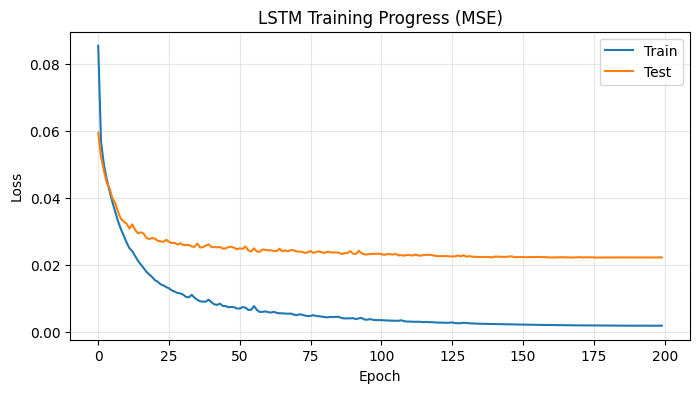

In [385]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.title("LSTM Training Progress (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

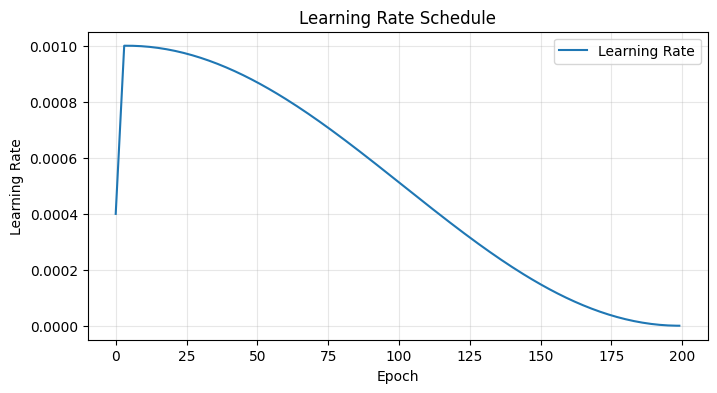

In [386]:
# Plot the learning rate schedule
plt.figure(figsize=(8, 4))
plt.plot(learning_rates, label="Learning Rate")
plt.title("Learning Rate Schedule")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [387]:
# Save the final model
torch.save(model.state_dict(), '../../data/tobias/lstm_model_final.pth')
print("Model saved to lstm_model_final.pth")

# Save complete model with architecture and filter configuration
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'test_losses': test_losses,
    'learning_rates': learning_rates,
    'hyperparameters': {
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'warmup_epochs': warmup_epochs,
        'max_epochs': max_epochs,
        'eta_min': eta_min,
        'window_size': window_size,
        'stride': stride,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'dropout': dropout,
        'sampling_rate': MEASURED_SAMPLE_RATE,  # ← Add sampling rate
        'filter_type': FILTER_TYPE,  # ← Add filter type
        'filter_config': FILTER_CONFIG,  # ← Add filter config
    }
}, '../../data/tobias/lstm_model_complete.pth')
print("Complete model checkpoint saved to lstm_model_complete.pth")
print(f"  Filter: {FILTER_TYPE} with config {FILTER_CONFIG}")
print(f"  Sampling rate: {MEASURED_SAMPLE_RATE:.4f} Hz")

Model saved to lstm_model_final.pth
Complete model checkpoint saved to lstm_model_complete.pth
  Filter: none with config {'cutoff': 0.5, 'order': 4}
  Sampling rate: 5.5615 Hz


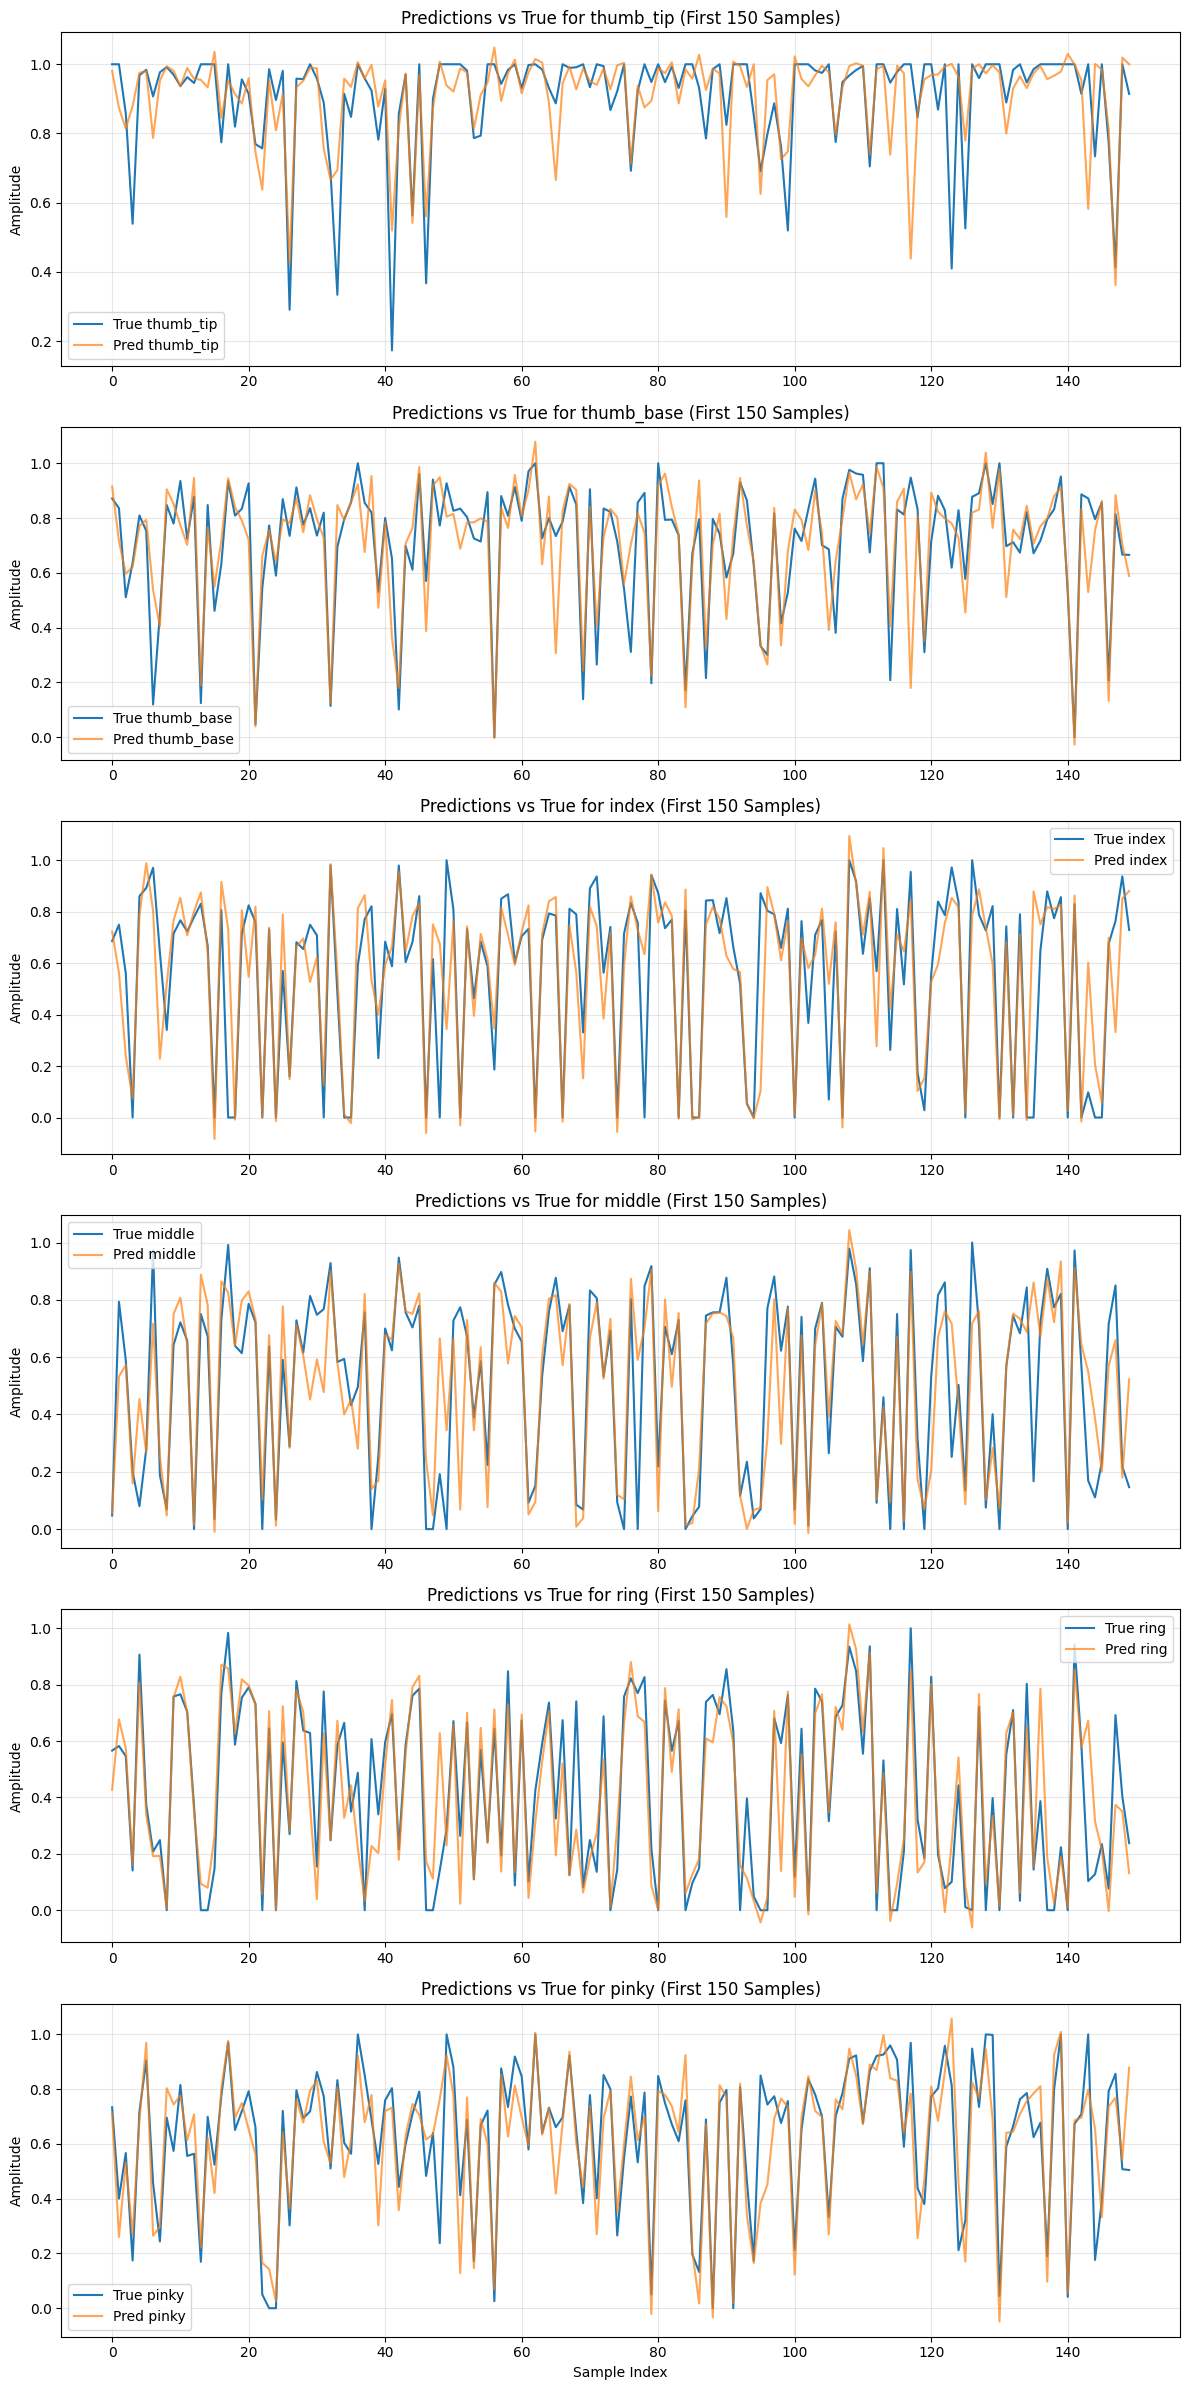

In [388]:
model.eval()
y_true = []
y_pred = []

# Collect predictions and ground truth for multiple batches
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb).cpu().numpy()
        y_true.append(yb.cpu().numpy())
        y_pred.append(preds)

# Concatenate all batches
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

finger_names = ['thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky']

# Plot 200 data points, one figure per finger
plt.figure(figsize=(12, len(finger_names) * 4))  # Adjust height for better spacing
for i, name in enumerate(finger_names):
    plt.subplot(len(finger_names), 1, i + 1)  # One row per finger
    plt.plot(y_true[:150, i], label=f"True {name}")
    plt.plot(y_pred[:150, i], label=f"Pred {name}", alpha=0.7)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title(f"Predictions vs True for {name} (First 150 Samples)", fontsize=12)
    plt.ylabel("Amplitude")
plt.xlabel("Sample Index")
plt.tight_layout()
plt.show()

In [389]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Overall Test Metrics:")
print(f"  MSE: {mse:.6f}")
print(f"  MAE: {mae:.6f}")
print(f"  R²:  {r2:.4f}")


finger_names = ['thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky']

print("\nPer-finger metrics:")
for i, name in enumerate(finger_names):
    mse_i = mean_squared_error(y_true[:, i], y_pred[:, i])
    mae_i = mean_absolute_error(y_true[:, i], y_pred[:, i])
    r2_i = r2_score(y_true[:, i], y_pred[:, i])
    print(f"  {name:<12} | MSE: {mse_i:.6f} | MAE: {mae_i:.6f} | R²: {r2_i:.4f}")

Overall Test Metrics:
  MSE: 0.022314
  MAE: 0.093439
  R²:  0.7293

Per-finger metrics:
  thumb_tip    | MSE: 0.013109 | MAE: 0.067523 | R²: 0.6453
  thumb_base   | MSE: 0.016394 | MAE: 0.085708 | R²: 0.7362
  index        | MSE: 0.032236 | MAE: 0.105836 | R²: 0.7550
  middle       | MSE: 0.024762 | MAE: 0.099990 | R²: 0.7648
  ring         | MSE: 0.022940 | MAE: 0.099653 | R²: 0.7713
  pinky        | MSE: 0.024440 | MAE: 0.101922 | R²: 0.7035
